# Notebook Overview for the Study:
## Does Freedom Bring Safety to a Country? An Empirical Examination

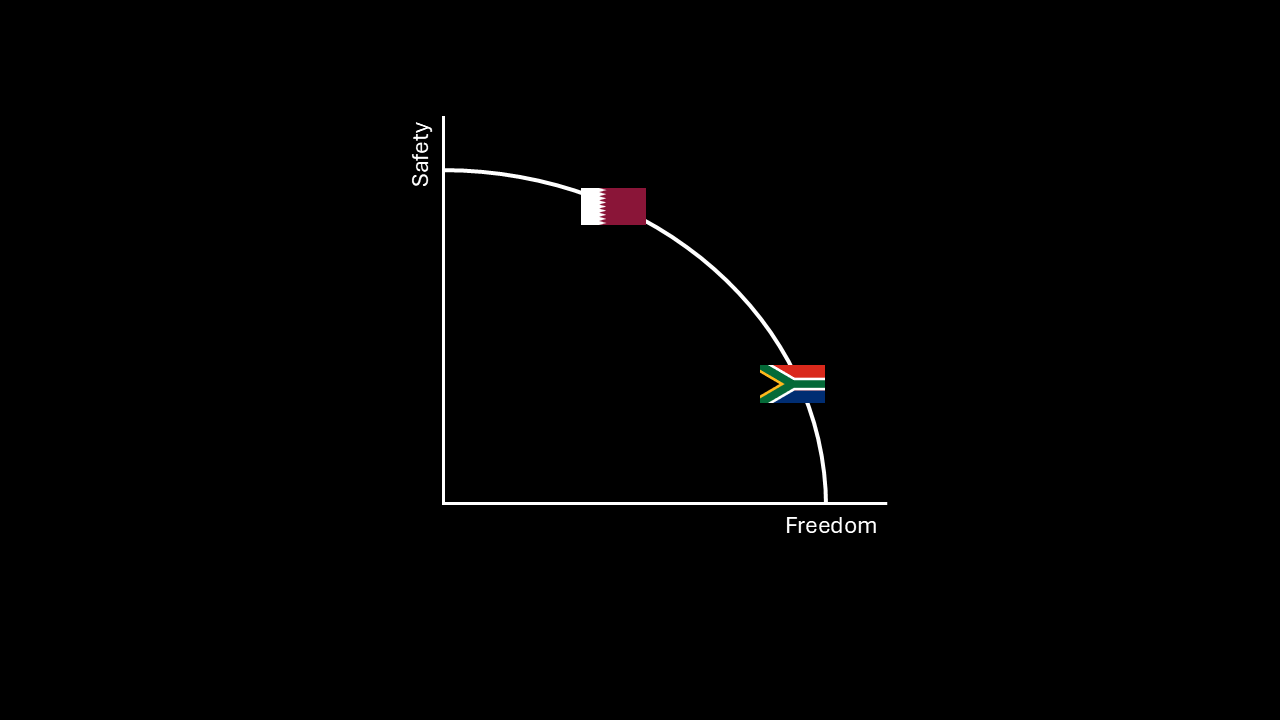

This notebook explores the relationship between freedom, safety, and other societal metrics across countries. It combines statistical analysis, visualization, and machine learning to uncover insights. The workflow includes data cleaning and preprocessing, correlation analysis, regression modeling, and comparative visualizations of key variables. Special focus is given to analyzing violent crime rates, women's safety metrics, and the theoretical trade-off between freedom and safety, with specific comparisons between South Africa and Qatar. The notebook concludes with predictive modeling using ElasticNet regression to identify key factors influencing freedom. This analysis aims to provide a comprehensive understanding of global safety and freedom dynamics.

In [ ]:
# Import libraries for correlation analysis, modeling, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

## Load and Prepare Data for Analysis
This code loads two datasets (`freedom.csv` and `safety.csv`), merges them on the `country` column, and performs data preprocessing. It drops irrelevant columns, renames key variables, and prepares the data by excluding country-specific columns to focus on numerical analysis.

In [ ]:
# Load and merge datasets
df = pd.merge(pd.read_csv('freedom.csv'), pd.read_csv('safety.csv'), on='country')

# Drop unnecessary columns and rename the relevant ones
data_country = (
    df.drop(columns=['MostPeaceful2022GPI', 'MostPeaceful2021GPI'])
      .rename(columns={
          'freedomIndexByCountry_humanFreedom2023': 'freedom',
          'MostPeaceful2023GPI': 'peaceful'
      })
)

# Create a DataFrame excluding country-specific columns
data = data_country.drop(columns=['country', 'freedomIndexByCountry_persFreedom2023', 'freedomIndexByCountry_econFreedom2023'])
data

,freedom,peaceful
0,6.290000,2.314000
1,5.150000,2.009000
2,8.390000,2.448000
3,6.620000,1.829000
4,5.490000,2.745000
...,...,...
147,6.740000,2.134000
148,6.690000,1.496000
149,7.800000,1.772000
150,8.730000,1.124000


## Analyze Correlation and Perform Regression
This code normalizes the numerical data using `StandardScaler` and calculates the Pearson correlation coefficient to measure the relationship between peacefulness and freedom. It then performs a linear regression analysis to predict peacefulness based on freedom and visualizes the results using a scatterplot with a regression line.

Pearson's correlation: -0.7374
                            OLS Regression Results                            
Dep. Variable:               peaceful   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     178.8
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           2.43e-27
Time:                        13:54:35   Log-Likelihood:                -156.04
No. Observations:                 152   AIC:                             316.1
Df Residuals:                     150   BIC:                             322.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.622e-16

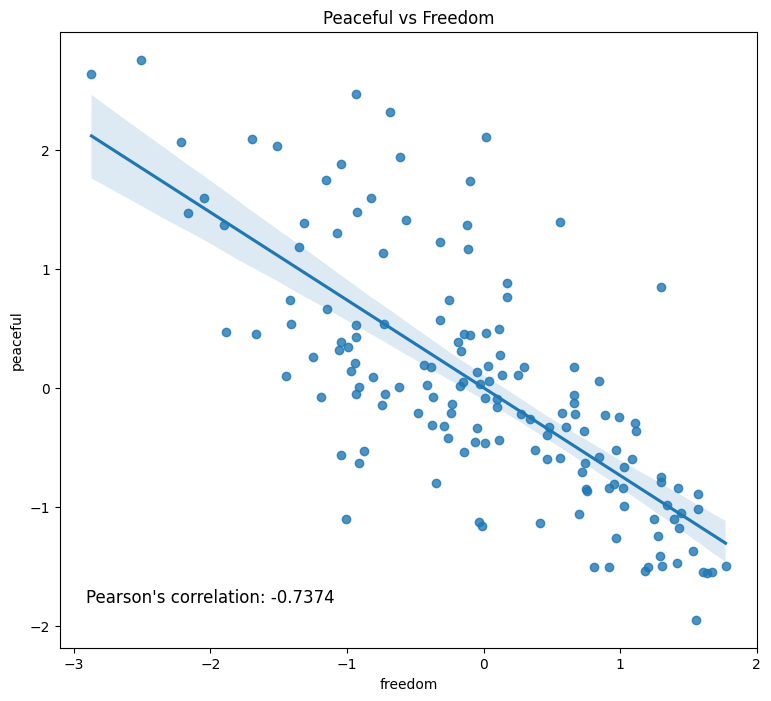

In [ ]:
# Normalize the data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Compute and display Pearson's correlation
corr, _ = pearsonr(data_scaled['peaceful'], data_scaled['freedom'])
print(f"Pearson's correlation: {corr:.4f}")

# Perform regression analysis predicting peacefulness from freedom
import statsmodels.api as sm

X = sm.add_constant(data_scaled['freedom'])  # Add a constant for the intercept
y = data_scaled['peaceful']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

# Plot the correlation
plt.figure(figsize=(9, 8))
sns.regplot(data=data_scaled, x='freedom', y='peaceful')
plt.title('Peaceful vs Freedom')
plt.text(-2, -1.8, f"Pearson's correlation: {corr:.4f}", fontsize=12, ha='center')
plt.show()


## Plot the Production Possibility Frontier (PPF)
This code defines a function to calculate a theoretical safety index based on freedom using a quadratic relationship. It then plots the Production Possibility Frontier (PPF) both as a standalone curve and with data points for selected countries (South Africa and Qatar). The visualization helps compare actual safety scores against the PPF model.

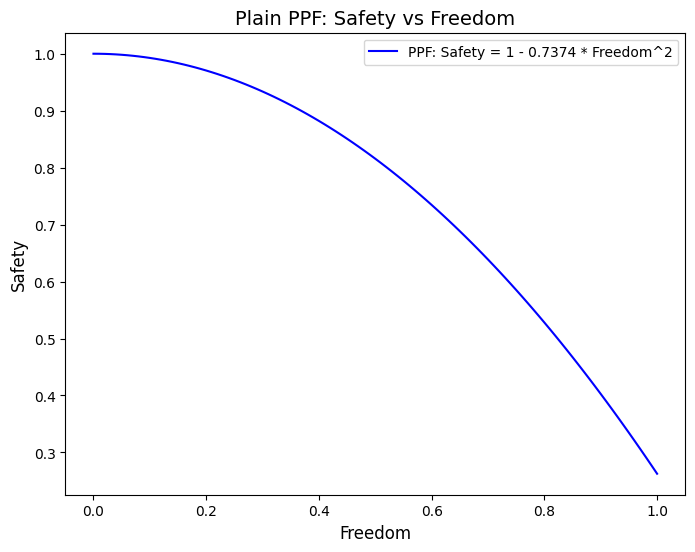

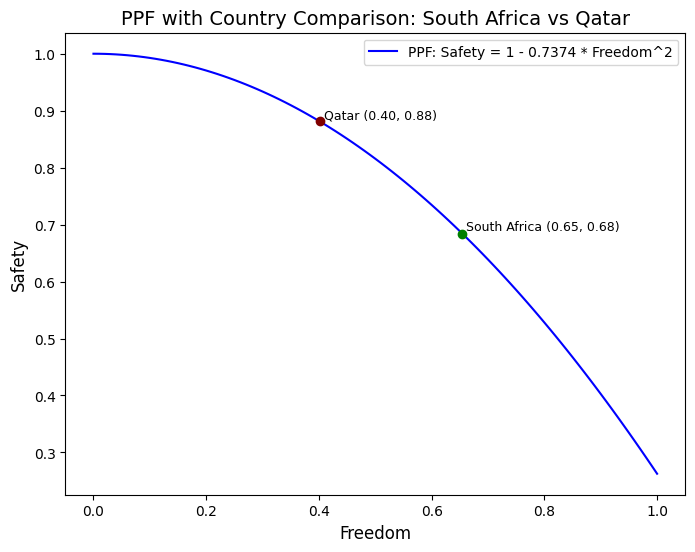

In [ ]:
# Define the safety function
def safety(freedom):
    return 1 - 0.7374 * freedom**2

# Generate freedom values for the PPF
freedom = np.arange(0, 1.01, 0.01)
safety_values = safety(freedom)

# Load and process the data
freedom_df = pd.read_csv('freedom.csv')  # Replace with your file path
freedom_df['Freedom'] = MinMaxScaler((0, 1)).fit_transform(freedom_df[['freedomIndexByCountry_humanFreedom2023']])
freedom_df_2 = freedom_df[freedom_df['country'].isin(['Qatar', 'South Africa'])].copy()
freedom_df_2['Safety'] = safety(freedom_df_2['Freedom'])

# Function to plot PPF with optional country data
def plot_ppf(include_countries=False):
    plt.figure(figsize=(8, 6))
    plt.plot(freedom, safety_values, label='PPF: Safety = 1 - 0.7374 * Freedom^2', color='blue')

    if include_countries:
        country_colors = {'South Africa': 'green', 'Qatar': 'maroon'}
        for _, row in freedom_df_2.iterrows():
            plt.scatter(row['Freedom'], row['Safety'], color=country_colors.get(row['country'], 'red'), zorder=5)
            plt.text(row['Freedom'], row['Safety'],
                     f" {row['country']} ({row['Freedom']:.2f}, {row['Safety']:.2f})",
                     fontsize=9, verticalalignment='bottom')
        plt.title('PPF with Country Comparison: South Africa vs Qatar', fontsize=14)
    else:
        plt.title('Plain PPF: Safety vs Freedom', fontsize=14)

    plt.xlabel('Freedom', fontsize=12)
    plt.ylabel('Safety', fontsize=12)
    plt.legend()
    plt.grid(False)
    plt.show()

# Plot 1: Plain PPF
plot_ppf(include_countries=False)

# Plot 2: PPF with country comparison
plot_ppf(include_countries=True)


## Analyze Violent Crime Rates by Country
This block defines a function to clean and preprocess a violent crime dataset by filtering and renaming columns. It then visualizes crime rates in South Africa and Qatar using bar charts in both actual and logarithmic scales, highlighting the differences in violent crime profiles between the two countries.

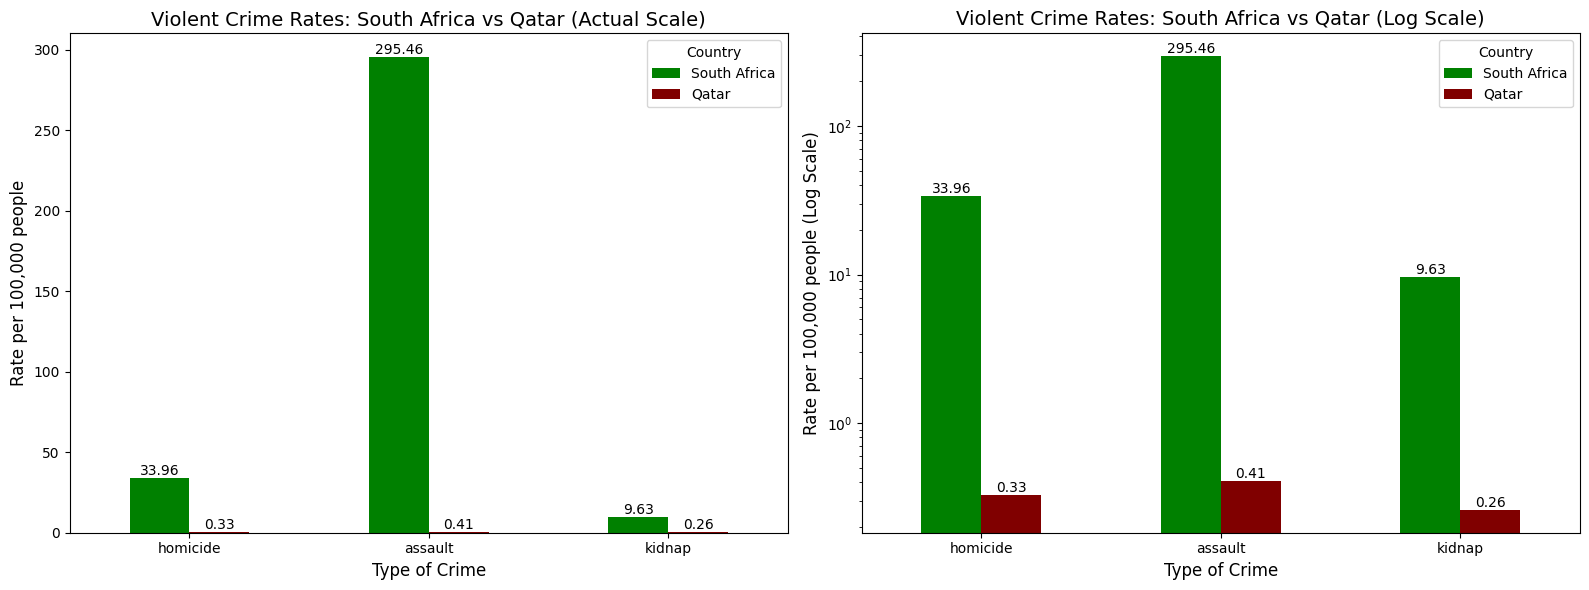

In [ ]:
def clean_data(df):
    # Filter countries and rename columns with a loop
    df = df[df['country'].isin(['Qatar', 'South Africa'])]
    rename_cols = {
        'violentCrimeRatesByCountry_homRate': 'homicide',
        'violentCrimeRatesByCountry_assault': 'assault',
        'violentCrimeRatesByCountry_kidnap': 'kidnap'
    }
    df = df.rename(columns=rename_cols)

    # Drop specified columns
    drop_cols = [col for col in df.columns if 'Year' in col or 'robbery' in col or 'sexViolence' in col]
    return df.drop(columns=drop_cols)

# Load data and apply cleaning
df = pd.read_csv('violent-crime.csv')
sa_vs_qatar = clean_data(df.copy())

# Prepare data for plotting
sa_vs_qatar_numeric = sa_vs_qatar.set_index('country').apply(pd.to_numeric, errors='coerce')
colors = {'South Africa': 'green', 'Qatar': 'maroon'}

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
titles = ['Violent Crime Rates: South Africa vs Qatar (Actual Scale)',
          'Violent Crime Rates: South Africa vs Qatar (Log Scale)']
scales = [None, 'log']

# Generate plots using a loop
for i, ax in enumerate(axes):
    sa_vs_qatar_numeric.T.plot(kind='bar', ax=ax, color=[colors[country] for country in sa_vs_qatar_numeric.index], logy=(scales[i]=='log'))
    ax.set_title(titles[i], fontsize=14)
    ax.set_ylabel(f'Rate per 100,000 people{(" (Log Scale)" if scales[i]=="log" else "")}', fontsize=12)
    ax.set_xlabel('Type of Crime', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Country')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

## Compare Women Safety Metrics
This code processes datasets on femicide rates and women's safety indices, focusing on South Africa and Qatar. After cleaning and merging the datasets, it visualizes the data using bar charts to compare femicide rates and peacefulness scores, emphasizing disparities in women's safety across the two countries.

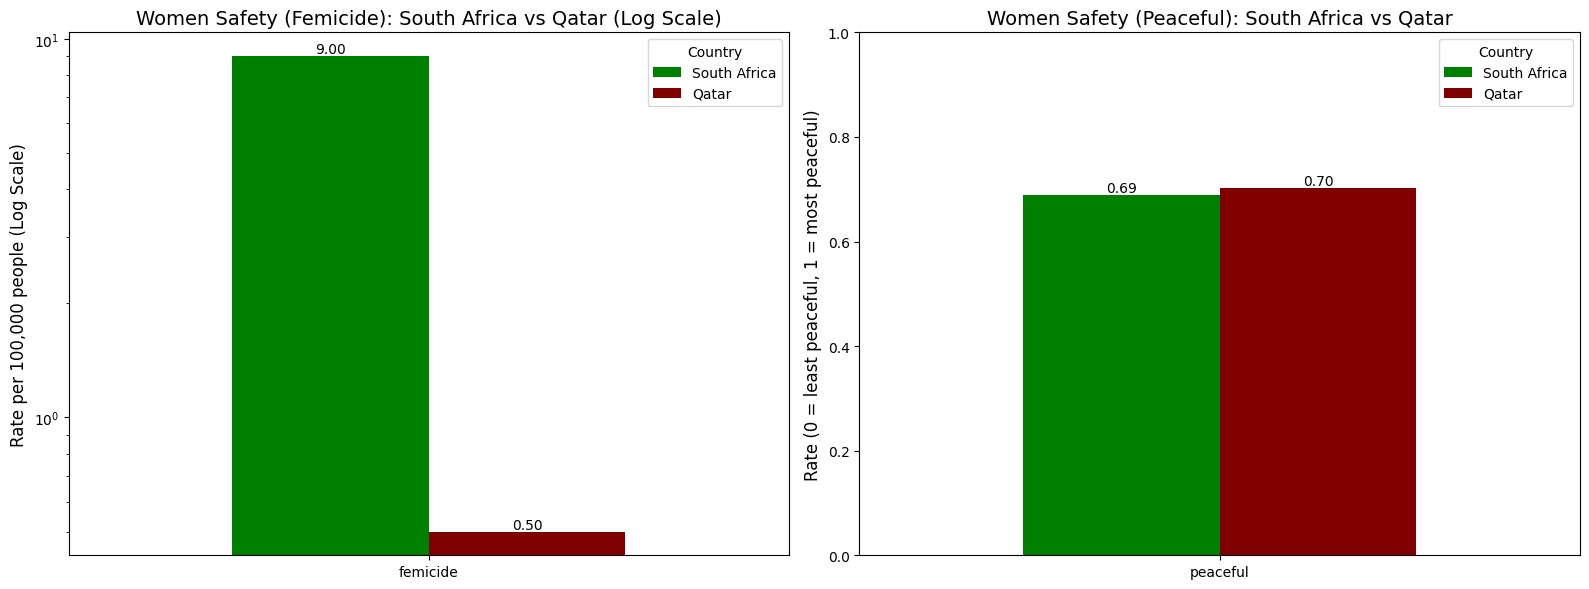

In [ ]:
def clean_data(df, drop_cols, rename_cols):
    # Drop specified columns and rename using dictionaries
    df = df.drop(columns=drop_cols).rename(columns=rename_cols)
    return df

# Load data, clean, and filter by country
df_femicide = pd.read_csv('femicide.csv')
femicide_cols = {'femicideRatesByCountry_rate': 'femicide'}
femicide = clean_data(df_femicide.copy(), ['FemicideRatesByCountryYearOfData'], femicide_cols)
femicide = femicide[femicide['country'].isin(['South Africa', 'Qatar'])]

df_dangerous = pd.read_csv('most-dangerous-for-women.csv')
dangerous_cols = {'MostDangerousCountriesForWomen_WomenPeaceAndSecurityIndex_Score_2023': 'peaceful'}
dangerous = clean_data(df_dangerous.copy(), [
    'MostDangerousCountriesForWomen_WomensDangerIndexWDI_TotalScore_2019',
    'MostDangerousCountriesForWomen_WDIStreetSafety_2019',
    'MostDangerousCountriesForWomen_WDIIntentionalHomicide_2019',
    'MostDangerousCountriesForWomen_WDINonPartnerViolence_2019',
    'MostDangerousCountriesForWomen_WDIIntimatePartnerViolence_2019',
    'MostDangerousCountriesForWomen_WDILegalDiscrimination_2019',
    'MostDangerousCountriesForWomen_WDIGlobalGenderGap_2019',
    'MostDangerousCountriesForWomen_WDIGenderInequality_2019',
    'MostDangerousCountriesForWomen_WDIAttitudesTowardViolence_2019'
], dangerous_cols)
dangerous = dangerous[dangerous['country'].isin(['South Africa', 'Qatar'])]

# Merge dataframes by 'country'
femicide_dangerous = pd.merge(femicide, dangerous, on='country').set_index('country')

# Define colors and create plots
colors = {'South Africa': 'green', 'Qatar': 'maroon'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
titles = ['Women Safety (Femicide): South Africa vs Qatar (Log Scale)',
          'Women Safety (Peaceful): South Africa vs Qatar']
y_labels = ['Rate per 100,000 people (Log Scale)', 'Rate (0 = least peaceful, 1 = most peaceful)']
vars_to_plot = ['femicide', 'peaceful']
y_lims = [None, (0, 1)]
scales = [True, False]

# Plot using a loop
for i, ax in enumerate([ax1, ax2]):
    femicide_dangerous[[vars_to_plot[i]]].T.plot(
        kind='bar',
        ax=ax,
        color=[colors[country] for country in femicide_dangerous.index],
        logy=scales[i],
        width=0.6
    )
    ax.set_title(titles[i], fontsize=14)
    ax.set_ylabel(y_labels[i], fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title='Country')
    ax.grid(False)
    if y_lims[i]:
        ax.set_ylim(y_lims[i])
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

## Predict Freedom Using Machine Learning
This block applies ElasticNet regression to predict the "Freedom" variable based on other features. It splits the dataset into training and testing sets, trains the model, and plots the top seven features with the highest importance. Additionally, it performs an Ordinary Least Squares (OLS) regression to evaluate the relationship between all features and "Freedom."

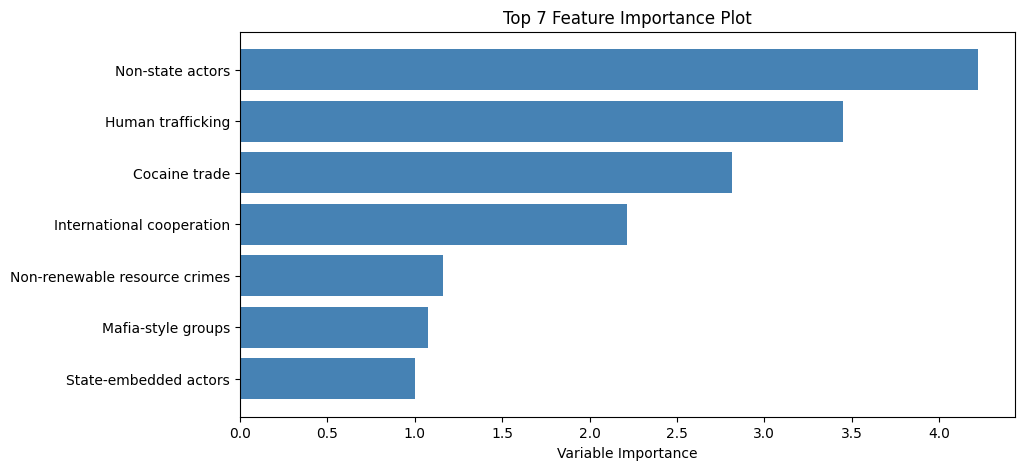

                            OLS Regression Results                            
Dep. Variable:                Freedom   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     21.00
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           3.84e-41
Time:                        13:54:41   Log-Likelihood:                -720.14
No. Observations:                 182   AIC:                             1510.
Df Residuals:                     147   BIC:                             1622.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [ ]:
# Load data
data = pd.read_csv('data_ml.csv')
X, y = data.drop(columns=["Freedom"]), data["Freedom"]

# Split data and train ElasticNet model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=0).fit(X_train, y_train)

# Calculate and plot top 7 feature importances
top_features = pd.DataFrame({
    "Features": X.columns,
    "Importance": np.abs(model.coef_)
}).nlargest(7, "Importance")

plt.figure(figsize=(10, 5))
plt.barh(top_features["Features"], top_features["Importance"], color="steelblue")
plt.xlabel("Variable Importance")
plt.title("Top 7 Feature Importance Plot")
plt.gca().invert_yaxis()
plt.show()

# OLS regression for predicting 'Freedom' from all features
X_ols = sm.add_constant(X)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())